In [54]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
#from pyTMD import predict
import numpy.ma as ma
from src.model_utils import calculate_ellipse_parameters
from src.pytmd_utils import tidal_ellipse

In [ ]:
# Unload the module if needed
import importlib, sys
if 'src.model_utils' in sys.modules:
    print("Module in it!")
    #del sys.modules['src.model_utils']
    importlib.reload(sys.modules['src.model_utils']) 

from src.model_utils import *

In [2]:
dtran = xr.open_zarr('../src/tpxo9.zarr', chunks='auto', decode_times=False)
print(dtran)

<xarray.Dataset>
Dimensions:       (constituents: 15, lat: 5401, lon: 10800)
Coordinates:
  * constituents  (constituents) <U3 'q1' 'o1' 'p1' 'k1' ... '2n2' 'mf' 'mm'
  * lat           (lat) float64 -90.0 -89.97 -89.93 -89.9 ... 89.93 89.97 90.0
  * lon           (lon) float64 0.03333 0.06667 0.1 0.1333 ... 359.9 360.0 360.0
Data variables:
    h_amp         (lat, lon, constituents) float64 dask.array<chunksize=(169, 338, 4), meta=np.ndarray>
    h_ph          (lat, lon, constituents) float64 dask.array<chunksize=(169, 338, 4), meta=np.ndarray>
    u_amp         (lat, lon, constituents) float64 dask.array<chunksize=(169, 338, 4), meta=np.ndarray>
    u_ph          (lat, lon, constituents) float64 dask.array<chunksize=(169, 338, 4), meta=np.ndarray>
    v_amp         (lat, lon, constituents) float64 dask.array<chunksize=(169, 338, 4), meta=np.ndarray>
    v_ph          (lat, lon, constituents) float64 dask.array<chunksize=(169, 338, 4), meta=np.ndarray>


In [3]:
dz = xr.open_zarr('../tpxo9_pytmd.zarr', chunks='auto', decode_times=False)
print(dz)

<xarray.Dataset>
Dimensions:       (constituents: 15, lat: 5401, lon: 10800)
Coordinates:
  * constituents  (constituents) <U3 'q1' 'o1' 'p1' 'k1' ... '2n2' 'mf' 'mm'
  * lat           (lat) float64 -90.0 -89.97 -89.93 -89.9 ... 89.93 89.97 90.0
  * lon           (lon) float64 0.03333 0.06667 0.1 0.1333 ... 359.9 360.0 360.0
Data variables:
    u_amp         (lat, lon, constituents) float64 dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    u_ph          (lat, lon, constituents) float64 dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    v_amp         (lat, lon, constituents) float64 dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    v_ph          (lat, lon, constituents) float64 dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    z_amp         (lat, lon, constituents) float64 dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    z_ph          (lat, lon, constituents) float64 dask.array<chunksize=(113, 113, 8), meta=np.ndarray>


In [4]:
#Tides at 18.92N, 69.97E Table 1 in https://drs.nio.res.in/drs/bitstream/handle/2264/4391/Cont_Shelf_Res_69_123a.pdf
#Observed tidal currents on the continental shelf off the west coast of India
#Location Latitude Longitude M2(a:cm,g:degree) S2 N2 K1 O1
#Mumbai 18.92 69.97 123.0 345.0 048.0 025.0 029.0 326.0 042.0 055.0 020.0 052.0
#Ratnagiri 16.98 73.30 066.3 317.2 026.3 355.8 015.0 297.0 034.5 053.6 016.1 057.2
#Marmagao 15.41 73.80 056.0 312.0 020.0 350.0 013.0 292.0 031.0 054.0 016.0 051.0
#Bhatkal 13.96 74.53 035.7 325.0 026.2 016.0 006.1 309.0 024.4 058.0 007.6 049.0
#Cochin 09.97 76.26 020.0 346.0 007.0 047.0 004.0 319.1 017.0 064.0 009.0 065.0

data = {
    "Location": ["Mumbai", "Ratnagiri", "Marmagao", "Bhatkal", "Cochin"],
    "Latitude": [18.92, 16.98, 15.41, 13.96, 9.97],
    "Longitude": [69.97, 73.30, 73.80, 74.53, 76.26],
    "M2_amp": [123.0, 66.3, 56.0, 35.7, 20.0],
    "M2_ph": [345.0, 317.2, 312.0, 325.0, 346.0],
    "S2_amp": [48.0, 26.3, 20.0, 26.2, 7.0],
    "S2_ph": [25.0, 355.8, 350.0, 16.0, 47.0],
    "N2_amp": [29.0, 15.0, 13.0, 6.1, 4.0],
    "N2_ph": [326.0, 297.0, 292.0, 309.0, 319.1],
    "K1_amp": [42.0, 34.5, 31.0, 24.4, 17.0],
    "K1_ph": [55.0, 53.6, 54.0, 58.0, 64.0],
    "O1_amp": [20.0, 16.1, 16.0, 7.6, 9.0],
    "O1_ph": [52.0, 57.2, 51.0, 49.0, 65.0]
}

paper_df = pd.DataFrame(data)
print(paper_df)


    Location  Latitude  Longitude  M2_amp  M2_ph  S2_amp  S2_ph  N2_amp  \
0     Mumbai     18.92      69.97   123.0  345.0    48.0   25.0    29.0   
1  Ratnagiri     16.98      73.30    66.3  317.2    26.3  355.8    15.0   
2   Marmagao     15.41      73.80    56.0  312.0    20.0  350.0    13.0   
3    Bhatkal     13.96      74.53    35.7  325.0    26.2   16.0     6.1   
4     Cochin      9.97      76.26    20.0  346.0     7.0   47.0     4.0   

   N2_ph  K1_amp  K1_ph  O1_amp  O1_ph  
0  326.0    42.0   55.0    20.0   52.0  
1  297.0    34.5   53.6    16.1   57.2  
2  292.0    31.0   54.0    16.0   51.0  
3  309.0    24.4   58.0     7.6   49.0  
4  319.1    17.0   64.0     9.0   65.0  


In [14]:
ilon = 73.3 #69.97
ilat = 16.98 #18.92
dsub = dz.sel(lon=slice(ilon-1/30, ilon+1), lat=slice(ilat-1/30, ilat+1))
# q1, o1, p1, k1, n2, m2, s1, s2, k2, m4, ms4, mn4, 2n2, mf, mm
print(dsub["z_amp"].isel(lon=0, lat=0).values)
print(dsub["z_ph"].isel(lon=0, lat=0).values)
m2_amp = dsub["z_amp"].isel(lon=0, lat=0).values[5] #vs 123.0
m2_ph = dsub["z_ph"].isel(lon=0, lat=0).values[5] #vs 345.0
s2_amp = dsub["z_amp"].isel(lon=0, lat=0).values[7] #vs 48.0
s2_ph = dsub["z_ph"].isel(lon=0, lat=0).values[7] #vs 25.0
n2_amp = dsub["z_amp"].isel(lon=0, lat=0).values[4] #vs 29.0
n2_ph = dsub["z_ph"].isel(lon=0, lat=0).values[4] #vs 326.0
k1_amp = dsub["z_amp"].isel(lon=0, lat=0).values[3] #vs 42.0
k1_ph = dsub["z_ph"].isel(lon=0, lat=0).values[3] #vs 55.0
o1_amp = dsub["z_amp"].isel(lon=0, lat=0).values[1] #vs 20.0
o1_ph = dsub["z_ph"].isel(lon=0, lat=0).values[1] #vs 52.0
print(m2_amp, s2_amp, n2_amp, k1_amp, o1_amp)
print(m2_ph, s2_ph, n2_ph, k1_ph, o1_ph)


[0.037      0.16308279 0.04252058 0.34258429 0.15597435 0.64132361
 0.01236932 0.24788103 0.06438168 0.01118034 0.00632456 0.00447214
 0.00894427 0.01118034 0.00608276]
[341.07535581 336.89367324 311.18592208 334.03331637 139.15964019
 165.18368545 104.03623932 193.53169257 186.24191363  63.43495161
 161.56505123  26.56505089  26.56505089  10.30484642   9.46232209]
0.6413236083984375 0.2478810272216797 0.15597434997558593 0.34258428955078124 0.16308279418945312
165.18368545379786 193.53169256710612 139.1596401876738 334.03331637007295 336.8936732359747


In [ ]:
# tsub = dtran.sel(lon=slice(ilon, ilon+1), lat=slice(ilat, ilat+1))
# q1, o1, p1, k1, n2, m2, s1, s2, k2, m4, ms4, mn4, 2n2, mf, mm
#print(tsub["h_amp"].isel(lon=0, lat=0).values)
#print(tsub["h_ph"].isel(lon=0, lat=0).values)
#m2_amp = tsub["h_amp"].isel(lon=0, lat=0).values[5] #vs 123.0
#m2_ph = tsub["h_ph"].isel(lon=0, lat=0).values[5] #vs 345.0
#s2_amp = tsub["h_amp"].isel(lon=0, lat=0).values[7] #vs 48.0
#s2_ph = tsub["h_ph"].isel(lon=0, lat=0).values[7] #vs 25.0
#n2_amp = tsub["h_amp"].isel(lon=0, lat=0).values[4] #vs 29.0
#n2_ph = tsub["h_ph"].isel(lon=0, lat=0).values[4] #vs 326.0
#k1_amp = tsub["h_amp"].isel(lon=0, lat=0).values[3] #vs 42.0
#k1_ph = tsub["h_ph"].isel(lon=0, lat=0).values[3] #vs 55.0
#o1_amp = tsub["h_amp"].isel(lon=0, lat=0).values[1] #vs 20.0
#o1_ph = tsub["h_ph"].isel(lon=0, lat=0).values[1] #vs 52.0
#print(m2_amp, s2_amp, n2_amp, k1_amp, o1_amp)
#print(m2_ph, s2_ph, n2_ph, k1_ph, o1_ph)
# the same

In [4]:
def extract_from_zarr(lon, lat, dz):
    grid_sz=1/30
    dsub = dz.sel(lon=slice(lon-grid_sz, lon+grid_sz), lat=slice(lat-grid_sz, lat+grid_sz))
    zarr_values = {
        "M2_amp": dsub["z_amp"].isel(lon=0, lat=0).values[5],
        "M2_ph": dsub["z_ph"].isel(lon=0, lat=0).values[5],
        "S2_amp": dsub["z_amp"].isel(lon=0, lat=0).values[7],
        "S2_ph": dsub["z_ph"].isel(lon=0, lat=0).values[7],
        "N2_amp": dsub["z_amp"].isel(lon=0, lat=0).values[4],
        "N2_ph": dsub["z_ph"].isel(lon=0, lat=0).values[4],
        "K1_amp": dsub["z_amp"].isel(lon=0, lat=0).values[3],
        "K1_ph": dsub["z_ph"].isel(lon=0, lat=0).values[3],
        "O1_amp": dsub["z_amp"].isel(lon=0, lat=0).values[1],
        "O1_ph": dsub["z_ph"].isel(lon=0, lat=0).values[1]
    }
    return zarr_values



In [ ]:
zarr_df = paper_df.apply(lambda row: extract_from_zarr(row['Longitude'], row['Latitude'], dz), axis=1, result_type='expand')
print(zarr_df)

In [ ]:
def plot_scatter(x, y, title, xlabel, ylabel):
    plt.scatter(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    corr_coef = np.corrcoef(x, y)[0, 1]
    r_squared = corr_coef ** 2
    plt.figtext(0.15, 0.2, f'Correlation Coefficient: {corr_coef:.2f}\nR-squared: {r_squared:.2f}', fontsize=9, ha='center')
    plt.show()

amp = np.concatenate((zarr[0], x[1]))

# Example for M2_amp
plot_scatter(paper_df["M2_amp"], zarr_df["M2_amp"], "Comparison of M2_amp", "Paper Table", "Zarr Dataset")


In [5]:
def plot_scatter_combined(paper_df, zarr_df, constituents, type):
    # Define a list of distinct colors (more can be added if needed)
    colors = ['r', 'g', 'b', 'y', 'm', 'c']
    
    # Check if provided constituents and colors match
    if len(constituents) > len(colors):
        raise ValueError("Not enough colors defined for the number of constituents.")
    
    plt.figure(figsize=(10, 8))
    
    for i, constituent in enumerate(constituents):
        x = paper_df[f"{constituent}_{type}"]
        y = zarr_df[f"{constituent}_{type}"]
        x = np.nan_to_num(x)
        y = np.nan_to_num(y)

        # Calculate statistics for each constituent
        corr_coef = np.corrcoef(x, y)[0, 1]
        r_squared = corr_coef ** 2
        label = f"{constituent} (Correlation Coefficient: {corr_coef:.2f}, R-squared: {r_squared:.2f})"
        
        # Scatter plot with unique color and label
        plt.scatter(x, y, color=colors[i], label=label)
    
    plt.title(f"Comparison of {type.upper()} between Paper Table and Zarr Dataset")
    plt.xlabel("Paper Table Values")
    plt.ylabel("Zarr Dataset Values")
    plt.legend()
    plt.show()

In [ ]:
# To use the function
constituents = ["M2", "S2", "N2", "K1", "O1"]

# For amplitude comparison
plot_scatter_combined(paper_df, zarr_df, constituents, "amp")

# For phase comparison
plot_scatter_combined(paper_df, zarr_df, constituents, "ph")

In [6]:
# Convert D and M format to Decimal
def convert_dm_to_decimal(dm_string):
    degree, minute = dm_string.split('D')
    minute = int(minute[:-1])  # Remove 'M' from the minute string
    return int(degree) + minute/60.0



In [14]:
#Incremental inference of boundary forcingfor a three-dimensional tidal model: tides in the Taiwan Strait
#constituents = ["M2", "S2", "N2", "K1", "O1"]
raw_data = {
    "Station": ["Matsu", "Wuchou", "Kinmen", "Taipower1", "Tamsuei", "Hsinchu", "Taichung", "Budai", "Dongee", "Kaohsiung", "Taipower3"],
    "Lat": ["26D10M", "24D59M", "24D24M", "25D18M", "25D11M", "24D51M", "24D20M", "23D23M", "23D15M", "22D37M", "21D57M"],
    "Lon": ["119D57M", "119D27M", "118D25M", "121D36M", "121D24M", "120D55M", "120D33M", "120D09M", "119D40M", "120D17M", "120D45M"],
    "O1_amp": [0.25, 0.25, 0.27, 0.18, 0.18, 0.20, 0.20, 0.19, 0.19, 0.16, 0.20],
    "O1_ph": [88, 112, 124, 92, 97, 106, 115, 126, 125, 129, 105],
    "K1_amp": [0.31, 0.39, 0.33, 0.21, 0.20, 0.23, 0.24, 0.21, 0.20, 0.18, 0.22],
    "K1_ph": [120, 147, 157, 116, 126, 134, 145, 161, 159, 167, 134],
    "N2_amp": [0.40, 0.35, 0.31, 0.10, 0.20, 0.30, 0.33, 0.12, 0.09, 0.04, 0.05],
    "N2_ph": [42, 56, 91, 45, 61, 64, 67, 55, 53, 333, 309],
    "M2_amp": [2.10, 2.05, 1.70, 0.47, 0.99, 1.61, 1.73, 0.63, 0.50, 0.18, 0.26],
    "M2_ph": [64, 89, 112, 73, 80, 85, 90, 75, 79, 351, 312],
    "S2_amp": [0.66, 0.55, 0.49, 0.12, 0.30, 0.47, 0.50, 0.16, 0.10, 0.07, 0.11],
    "S2_ph": [96, 126, 152, 92, 112, 118, 123, 107, 112, 353, 323]
}

# Applying the conversion function to the Lat and Lon columns
raw_data["Latitude"] = [convert_dm_to_decimal(lat) for lat in raw_data["Lat"]]
raw_data["Longitude"] = [convert_dm_to_decimal(lon) for lon in raw_data["Lon"]]

# Removing the old Lat and Lon columns
del raw_data["Lat"]
del raw_data["Lon"]

# Reformatting the dictionary to match the structure of paper_df
data = {
    "Location": raw_data["Station"],
    "Latitude": raw_data["Latitude"],
    "Longitude": raw_data["Longitude"],
    "O1_amp": raw_data["O1_amp"],
    "O1_ph": raw_data["O1_ph"],
    "K1_amp": raw_data["K1_amp"],
    "K1_ph": raw_data["K1_ph"],
    "N2_amp": raw_data["N2_amp"],
    "N2_ph": raw_data["N2_ph"],
    "M2_amp": raw_data["M2_amp"],
    "M2_ph": raw_data["M2_ph"],
    "S2_amp": raw_data["S2_amp"],
    "S2_ph": raw_data["S2_ph"]
}

paper2_df = pd.DataFrame(data)
print(paper2_df)


     Location   Latitude   Longitude  O1_amp  O1_ph  K1_amp  K1_ph  N2_amp  \
0       Matsu  26.166667  119.950000    0.25     88    0.31    120    0.40   
1      Wuchou  24.983333  119.450000    0.25    112    0.39    147    0.35   
2      Kinmen  24.400000  118.416667    0.27    124    0.33    157    0.31   
3   Taipower1  25.300000  121.600000    0.18     92    0.21    116    0.10   
4     Tamsuei  25.183333  121.400000    0.18     97    0.20    126    0.20   
5     Hsinchu  24.850000  120.916667    0.20    106    0.23    134    0.30   
6    Taichung  24.333333  120.550000    0.20    115    0.24    145    0.33   
7       Budai  23.383333  120.150000    0.19    126    0.21    161    0.12   
8      Dongee  23.250000  119.666667    0.19    125    0.20    159    0.09   
9   Kaohsiung  22.616667  120.283333    0.16    129    0.18    167    0.04   
10  Taipower3  21.950000  120.750000    0.20    105    0.22    134    0.05   

    N2_ph  M2_amp  M2_ph  S2_amp  S2_ph  
0      42    2.10    

In [13]:
zarr2_df = paper2_df.apply(lambda row: extract_from_zarr(row['Longitude'], row['Latitude'], dz), axis=1, result_type='expand')
print(zarr2_df)

      M2_amp       M2_ph    S2_amp       S2_ph    N2_amp       N2_ph  \
0   2.094973   66.212455  0.659831   96.177171  0.389616   44.896015   
1   2.163601   88.649312  0.601295  129.195542  0.389298   70.960003   
2   1.713754  107.768869  0.486625  157.017853  0.332024   90.690275   
3        NaN         NaN       NaN         NaN       NaN         NaN   
4   0.948773         NaN  0.240169         NaN  0.180624         NaN   
5   1.525808         NaN  0.437120         NaN  0.305011         NaN   
6        NaN         NaN       NaN         NaN       NaN         NaN   
7   0.635852   78.018526  0.146185  110.418423  0.134469   42.588968   
8   0.520219   84.705855  0.100603  127.325518  0.098813   54.057887   
9   0.188693  345.890112  0.068447  348.197565  0.046519  334.536655   
10  0.280189  317.024764  0.112699  333.662312  0.058258  309.427804   

      K1_amp       K1_ph    O1_amp       O1_ph  
0   0.308974  119.468861  0.250072   91.374831  
1   0.300375  140.267702  0.257099  1

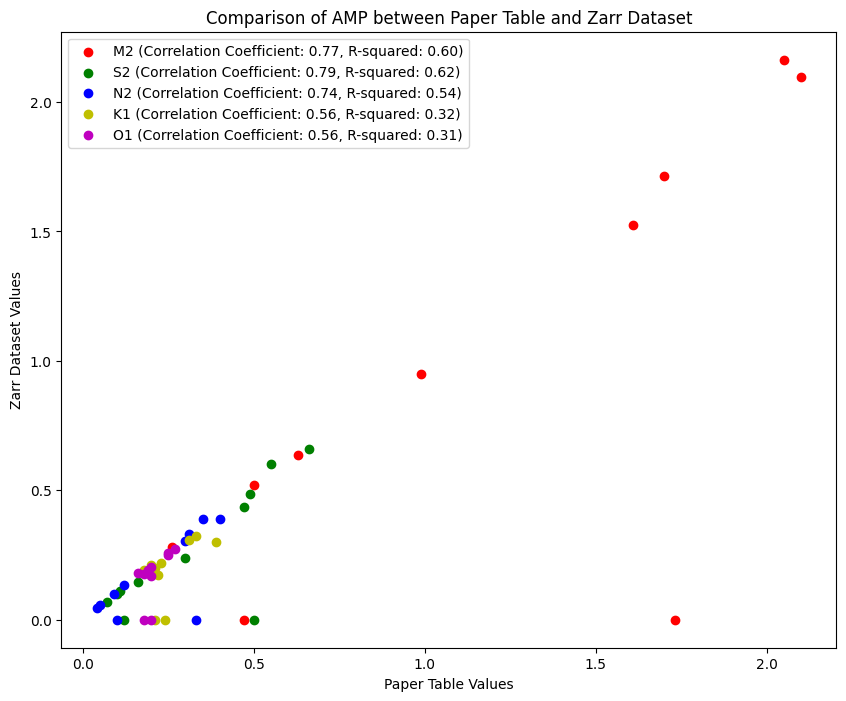

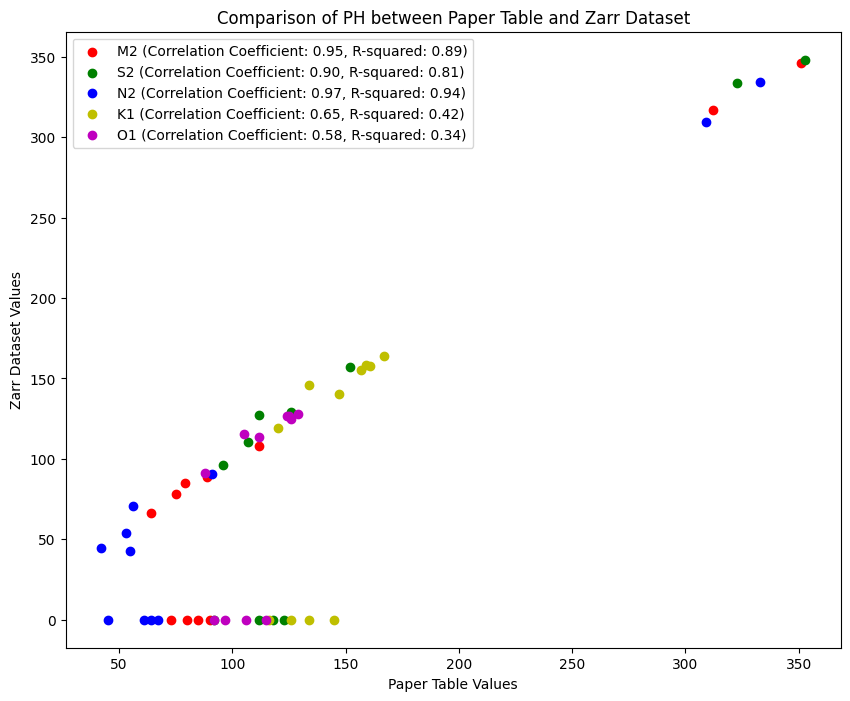

In [15]:
# For amplitude comparison
plot_scatter_combined(paper2_df, zarr2_df, constituents, "amp")

# For phase comparison
plot_scatter_combined(paper2_df, zarr2_df, constituents, "ph")

In [41]:
# Create a DataFrame for the u, v values
data = {
    "Constituent": ["M2", "S2", "N2", "K1", "O1"],
    "Mumbai_u": [13.34, 5.58, 3.77, 6.02, 2.4],
    "Mumbai_v": [5.71, 2.55, 1.69, 3.81, 1.68],
    "Jaigarh_u": [17.58, 7.15, 4.37, 4.84, 3.28],
    "Jaigarh_v": [2.85, 1.40, 0.77, 1.83, 1.20],
    "Goa_u": [5.01, 1.81, 1.21, 1.91, 0.96],
    "Goa_v": [2.36, 1.33, 0.48, 1.08, 0.49],
    "Bhatkal_u": [4.11, 1.79, 0.85, 2.43, 1.03],
    "Bhatkal_v": [3.44, 1.61, 0.62, 3.00, 0.93],
    "Kollam_u": [2.26, 1.23, 0.56, 2.39, 1.21],
    "Kollam_v": [8.73, 3.63, 1.76, 5.22, 3.07]
}
df_uv = pd.DataFrame(data)

# Transpose the DataFrame and reformat it for easier merging
df_uv_t = df_uv.melt(id_vars="Constituent", var_name="Location_UV", value_name="Value")
df_uv_t["Location"] = df_uv_t["Location_UV"].apply(lambda x: x.split("_")[0])
df_uv_t["Type"] = df_uv_t["Location_UV"].apply(lambda x: x.split("_")[1])

df_wide = df_uv_t.pivot_table(index=["Location", "Constituent"], columns="Type", values="Value").reset_index()

# Create a DataFrame for the datetime and location information
data_info = {
    "ADCP": ["M100", "J100", "G100", "B100", "K150"],
    "Location": ["Mumbai", "Jaigarh", "Goa", "Bhatkal", "Kollam"],
    "Latitude": [20.91, 17.15, 15.17, 13.67, 9.00],
    "Longitude": [69.23, 72.08, 73.19, 73.51, 75.96],
    "ADCP_Depth(m)": [79, 92, 90, 97, 154],
    "Water_Depth(m)": [112, 108, 98, 104, 179],
    "Coastal_angle": [20.91, 36.00, 21.40, 16.94, 30.57],
    "Start_date": ["21/Oct/08", "04/Mar/08", "02/Mar/08", "05/Mar/08", "20/Sep/10"],
    "End_date": ["12/Sep/09", "18/Oct/08", "22/Oct/08", "07/Sep/08", "25/Oct/11"]
}
df_info = pd.DataFrame(data_info)

# Merge the two DataFrames on the 'Location' column
df_merged = pd.merge(df_info, df_wide, on="Location")

print(df_merged)

    ADCP Location  Latitude  Longitude  ADCP_Depth(m)  Water_Depth(m)  \
0   M100   Mumbai     20.91      69.23             79             112   
1   M100   Mumbai     20.91      69.23             79             112   
2   M100   Mumbai     20.91      69.23             79             112   
3   M100   Mumbai     20.91      69.23             79             112   
4   M100   Mumbai     20.91      69.23             79             112   
5   J100  Jaigarh     17.15      72.08             92             108   
6   J100  Jaigarh     17.15      72.08             92             108   
7   J100  Jaigarh     17.15      72.08             92             108   
8   J100  Jaigarh     17.15      72.08             92             108   
9   J100  Jaigarh     17.15      72.08             92             108   
10  G100      Goa     15.17      73.19             90              98   
11  G100      Goa     15.17      73.19             90              98   
12  G100      Goa     15.17      73.19             

In [42]:
# Convert start and end date strings to datetime format
df_merged['Start_date'] = pd.to_datetime(df_merged['Start_date'], format='%d/%b/%y')
df_merged['End_date'] = pd.to_datetime(df_merged['End_date'], format='%d/%b/%y')

In [7]:
def get_tide_map_constituent(dz, tide_time,
            constituent=['q1','o1','p1','k1','n2','m2','s1','s2','k2','m4','ms4','mn4','2n2','mf','mm'],    
            format='netcdf', type=['u', 'v']):
    DELTAT = np.zeros_like(tide_time)
    
    # Filter the constituents based on the given input list
    c = dz.coords['constituents'].values
    c_filtered = [c_val for c_val in c if c_val in constituent]
    if len(c_filtered) != len(constituent):
        raise ValueError("Not all input constituents found in the dataset!")
    
    dz_filtered = dz.sel(constituents=c_filtered)
    timelen = len(tide_time)
    tide = {}

    for TYPE in type:
        amp = dz_filtered[TYPE+'_amp'].isel(lon=0, lat=0).values[:]
        ph = dz_filtered[TYPE+'_ph'].isel(lon=0, lat=0).values[:]  # Extract phase values
        amp = np.reshape(amp, (1,len(c_filtered)))
        ph = np.reshape(ph, (1,len(c_filtered)))
        # Calculate complex phase in radians for Euler's
        cph = -1j * ph * np.pi / 180.0
        # Calculate constituent oscillation
        hc = amp * np.exp(cph)
        
        # Mask where values are NA or 0
        mask = np.isnan(hc) | (hc == 0)
        # Convert hc to a masked array
        hc = ma.array(hc, mask=mask)

        tide[TYPE] = np.ma.zeros(timelen)
        for hour in range(timelen):
            TIDE = predict.map(tide_time[hour], hc, c_filtered, deltat=DELTAT[hour], corrections=format)
            MINOR = predict.infer_minor(tide_time[hour], hc, c_filtered, deltat=DELTAT[hour], corrections=format)
            tide[TYPE][hour] = TIDE + MINOR

    return tide


In [ ]:
# Assuming some location and corresponding data
loc_filter = df_merged['Location'] == "Mumbai"
start_date, end_date, x, y = df_merged.loc[loc_filter, ['Start_date', 'End_date', 'Longitude', 'Latitude']].iloc[0]
print(start_date, end_date, x, y)
grid_sz=1/30
dsub = dz.sel(lon=slice(x-grid_sz, x+grid_sz), lat=slice(y-grid_sz, y+grid_sz))
ampx1 = dsub['u_amp'].isel(lon=0, lat=0)
#ampx2 = dsub['u_amp'].isel(lon=1, lat=1)
print(dsub)
print(ampx1.values)
#print(ampx2.values)
# tide_time, dtime = get_tide_time(start_date, end_date)
# tides = get_tide_map_constituent(dsub, tide_time, ["m2", "s2", "n2", "k1", "o1"])

In [18]:
def get_tide_constituent(dz, mode="amp",
                         constituent=['q1', 'o1', 'p1', 'k1', 'n2', 'm2', 's1', 's2', 'k2', 'm4', 'ms4', 'mn4', '2n2', 'mf', 'mm'],    
                         type=['u', 'v']):
    # Filter the constituents based on the given input list
    c = dz.coords['constituents'].values
    c_filtered = [c_val for c_val in c if c_val in constituent]
    if len(c_filtered) != len(constituent):
        raise ValueError("Not all input constituents found in the dataset!")
    
    dz_filtered = dz.sel(constituents=c_filtered)
    
    # Dictionary to store the amplitudes
    amplitudes = {}
    phase = {}
    harmonic = {}

    for TYPE in type:
        for const in c_filtered:
            #print(const, dz_filtered[TYPE+'_amp'].sel(constituents=const).values)
            amp = dz_filtered[TYPE+'_amp'].sel(constituents=const).values
            key = f"{const}_{TYPE}"
            amplitudes[key] = amp
            ph = dz_filtered[TYPE+'_ph'].sel(constituents=const).values
            key = f"{const}_{TYPE}"
            phase[key] = ph
            cph = -1j * ph * np.pi / 180.0
            # Calculate constituent oscillation
            hc = amp * np.exp(cph)       
            # Mask where values are NA or 0
            # mask = np.isnan(hc) | (hc == 0)
            # Convert hc to a masked array
            # hc = ma.array(hc, mask=mask)
            harmonic[key] = hc

    if mode == 'amp':
        return amplitudes
    elif mode == 'ph':
        return phase
    return harmonic        

In [67]:
locations = ["Mumbai", "Jaigarh", "Goa", "Bhatkal", "Kollam"]

zarr_results = {}

for loc in locations:
    loc_filter = df_merged['Location'] == loc
    x, y = df_merged.loc[loc_filter, ['Longitude', 'Latitude']].iloc[0]
    dsub = dz.sel(lon=x, lat=y, method='nearest')
    zarr_results[loc] = get_tide_constituent(dsub, 'amp', ["m2", "s2", "n2", "k1", "o1"])

print(zarr_results)

{'Mumbai': {'o1_u': array(86.63529962), 'k1_u': array(249.87505289), 'n2_u': array(92.09232554), 'm2_u': array(301.50977788), 's2_u': array(183.56122268), 'o1_v': array(70.63151609), 'k1_v': array(186.66648092), 'n2_v': array(77.99011092), 'm2_v': array(491.57616956), 's2_v': array(158.23689982)}, 'Jaigarh': {'o1_u': array(228.09504875), 'k1_u': array(483.84244566), 'n2_u': array(462.69550305), 'm2_u': array(1815.97880259), 's2_u': array(746.26796545), 'o1_v': array(138.09602336), 'k1_v': array(395.62406514), 'n2_v': array(370.81572681), 'm2_v': array(1333.09830852), 's2_v': array(473.4771262)}, 'Goa': {'o1_u': array(43.75687899), 'k1_u': array(87.55497752), 'n2_u': array(97.4237964), 'm2_u': array(343.34462007), 's2_u': array(154.15608686), 'o1_v': array(61.51992554), 'k1_v': array(169.9269733), 'n2_v': array(97.95854423), 'm2_v': array(418.33923856), 's2_v': array(147.59051313)}, 'Bhatkal': {'o1_u': array(65.04406126), 'k1_u': array(114.34150313), 'n2_u': array(103.26995383), 'm2_u':

In [68]:
data = {
    "Constituent": ["M2", "S2", "N2", "K1", "O1"],
    "Mumbai_u": [13.34, 5.58, 3.77, 6.02, 2.4],
    "Mumbai_v": [5.71, 2.55, 1.69, 3.81, 1.68],
    "Jaigarh_u": [17.58, 7.15, 4.37, 4.84, 3.28],
    "Jaigarh_v": [2.85, 1.40, 0.77, 1.83, 1.20],
    "Goa_u": [5.01, 1.81, 1.21, 1.91, 0.96],
    "Goa_v": [2.36, 1.33, 0.48, 1.08, 0.49],
    "Bhatkal_u": [4.11, 1.79, 0.85, 2.43, 1.03],
    "Bhatkal_v": [3.44, 1.61, 0.62, 3.00, 0.93],
    "Kollam_u": [2.26, 1.23, 0.56, 2.39, 1.21],
    "Kollam_v": [8.73, 3.63, 1.76, 5.22, 3.07]
}

In [86]:
# Convert paper_data to paper_df
# paper_df = pd.DataFrame.from_dict(data).set_index('Constituent').transpose()
intermediate_df = pd.DataFrame.from_dict(data)

# Melt the DataFrame
melted_df = intermediate_df.melt(id_vars=["Constituent"], 
                                 value_vars=[col for col in intermediate_df.columns if col != "Constituent"],
                                 var_name="Location_Type", value_name="Value")

# Split Location and Type
location_type_df = melted_df['Location_Type'].str.split('_', expand=True)
melted_df['Location'] = location_type_df[0]
melted_df['Type'] = location_type_df[1]
melted_df.drop(columns=["Location_Type"], inplace=True)
#print(melted_df)

# Pivot table to desired format
paper_df = melted_df.pivot_table(index='Location', columns=['Constituent', 'Type'], values='Value').reset_index()
#print(paper_df)
#print(paper_df.columns[1:])
paper_df.columns = ['_'.join(col).strip() for col in paper_df.columns.values]
#print(paper_df)
paper_df.set_index('Location_', inplace=True)
#paper_df.drop(columns=['Location_'], inplace=True)
print(paper_df)


           K1_u  K1_v   M2_u  M2_v  N2_u  N2_v  O1_u  O1_v  S2_u  S2_v
Location_                                                             
Bhatkal    2.43  3.00   4.11  3.44  0.85  0.62  1.03  0.93  1.79  1.61
Goa        1.91  1.08   5.01  2.36  1.21  0.48  0.96  0.49  1.81  1.33
Jaigarh    4.84  1.83  17.58  2.85  4.37  0.77  3.28  1.20  7.15  1.40
Kollam     2.39  5.22   2.26  8.73  0.56  1.76  1.21  3.07  1.23  3.63
Mumbai     6.02  3.81  13.34  5.71  3.77  1.69  2.40  1.68  5.58  2.55


In [99]:
# Convert zarr_results to zarr_df
zarr_data = {}
locations = ["Mumbai", "Jaigarh", "Goa", "Bhatkal", "Kollam"]
types = ["u", "v"]

# Reformat zarr_results
for location in locations:
    for t in types:
        for const in constituents:
            key = f"{const}_{t}"
            if key not in zarr_data:
                zarr_data[key] = []
            
            # Check if the result is a list or array and if so, only append the first value
            result = zarr_results[location][key.lower()]
            #print(result)
            #if isinstance(result, (list, np.ndarray)) and len(result) == 1:
            #    zarr_data[key].append(result[0])
            #else:
            zarr_data[key].append(result)

zarr_df = pd.DataFrame(zarr_data, index=locations)
print(zarr_df)
print(zarr_df.shape)


                       M2_u                S2_u                N2_u  \
Mumbai   301.50977788282546   183.5612226768558    92.0923255370993   
Jaigarh  1815.9788025948467   746.2679654463443  462.69550304537785   
Goa       343.3446200696056  154.15608686194898   97.42379640371232   
Bhatkal   418.5962648416887   164.2396314313984  103.26995382585753   
Kollam    240.4011333626761   113.1794490903756    52.4563710387324   

                       K1_u               O1_u                M2_v  \
Mumbai   249.87505288694703  86.63529961622616  491.57616955902466   
Jaigarh   483.8424456580842  228.0950487525389  1333.0983085186256   
Goa       87.55497752320187  43.75687898781903   418.3392385563347   
Bhatkal   114.3415031332454  65.04406126319262   776.2782055873924   
Kollam   174.48199090375587  83.60832966549297    678.851913118527   

                       S2_v                N2_v                K1_v  \
Mumbai   158.23689982406765    77.9901109200169  186.66648091770452   
Jaigarh  4

In [89]:
paper_df.columns = [col.rstrip('_') if col.endswith('_') else col for col in paper_df.columns]
paper_df = paper_df.reindex(zarr_df.index)
# Check the ordering
print(paper_df)
print(zarr_df)

         K1_u  K1_v   M2_u  M2_v  N2_u  N2_v  O1_u  O1_v  S2_u  S2_v
Mumbai   6.02  3.81  13.34  5.71  3.77  1.69  2.40  1.68  5.58  2.55
Jaigarh  4.84  1.83  17.58  2.85  4.37  0.77  3.28  1.20  7.15  1.40
Goa      1.91  1.08   5.01  2.36  1.21  0.48  0.96  0.49  1.81  1.33
Bhatkal  2.43  3.00   4.11  3.44  0.85  0.62  1.03  0.93  1.79  1.61
Kollam   2.39  5.22   2.26  8.73  0.56  1.76  1.21  3.07  1.23  3.63
                       M2_u                S2_u                N2_u  \
Mumbai   301.50977788282546   183.5612226768558    92.0923255370993   
Jaigarh  1815.9788025948467   746.2679654463443  462.69550304537785   
Goa       343.3446200696056  154.15608686194898   97.42379640371232   
Bhatkal   418.5962648416887   164.2396314313984  103.26995382585753   
Kollam    240.4011333626761   113.1794490903756    52.4563710387324   

                       K1_u               O1_u                M2_v  \
Mumbai   249.87505288694703  86.63529961622616  491.57616955902466   
Jaigarh   483.84244

In [9]:
def plot_scatter_uv(paper_df, zarr_df, constituents, type):
    # Define a list of distinct colors (more can be added if needed)
    colors = ['r', 'g', 'b', 'y', 'm', 'c']
    
    # Check if provided constituents and colors match
    if len(constituents) > len(colors):
        raise ValueError("Not enough colors defined for the number of constituents.")
    
    plt.figure(figsize=(10, 8))
    
    for i, constituent in enumerate(constituents):
        x = paper_df[f"{constituent}_{type}"].values
        y = zarr_df[f"{constituent}_{type}"].values
        if isinstance(y, (list, np.ndarray)) and len(y) == 1:
            y = y[0]
        y = y/100.0 # to m/s    
        #print(x,y)

        # Calculate statistics for each constituent
        # corr_coef = np.corrcoef(x, y)[0, 1]
        # r_squared = corr_coef ** 2

        mean_x = np.mean(x)
        mean_y = np.mean(y)
        cov_xy = np.mean((x - mean_x) * (y - mean_y))
        std_x = np.std(x)
        std_y = np.std(y)
        corr_coef = cov_xy / (std_x * std_y)
        r_squared = corr_coef ** 2
        label = f"{constituent} (Correlation Coefficient: {corr_coef:.2f}, R-squared: {r_squared:.2f})"
        
        # Plotting
        #plt.subplot(2, 3, idx)
        #plt.scatter(x, y, label=f"{constituent} (Correlation Coefficient: {corr_coef:.2f}, R-squared: {r_squared:.2f})")
        #plt.xlabel('Paper Data')
        #plt.ylabel('Zarr Data')
        #plt.legend()
    
    #plt.tight_layout()
    #plt.show()

        # Scatter plot with unique color and label
        plt.scatter(x, y, color=colors[i], label=label)
    
    plt.title(f"Comparison of {type.upper()} between Paper Table and Zarr Dataset")
    plt.xlabel("Paper Table Values")
    plt.ylabel("Zarr Dataset Values")
    plt.legend()
    plt.show()
    


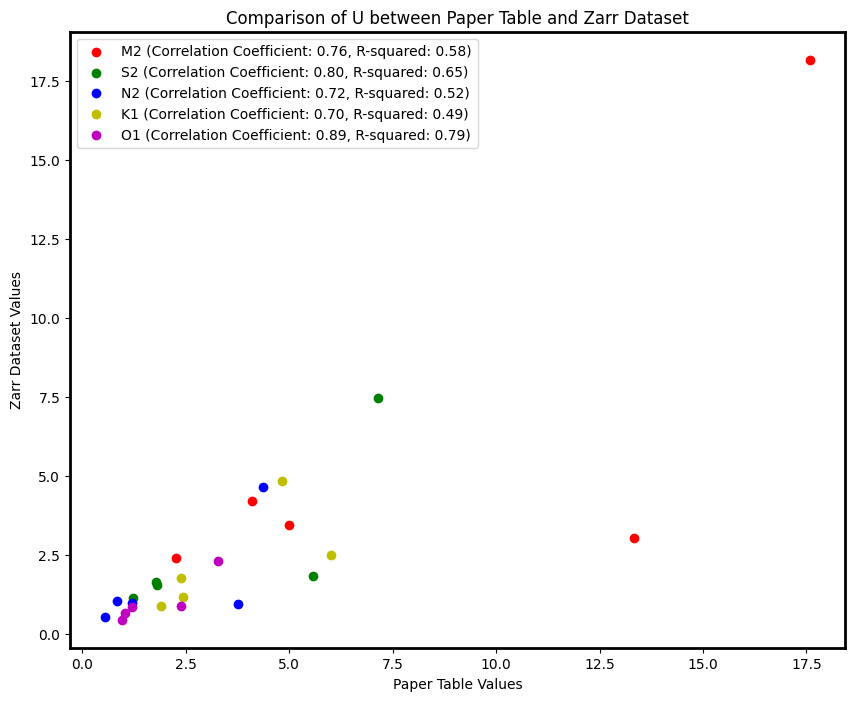

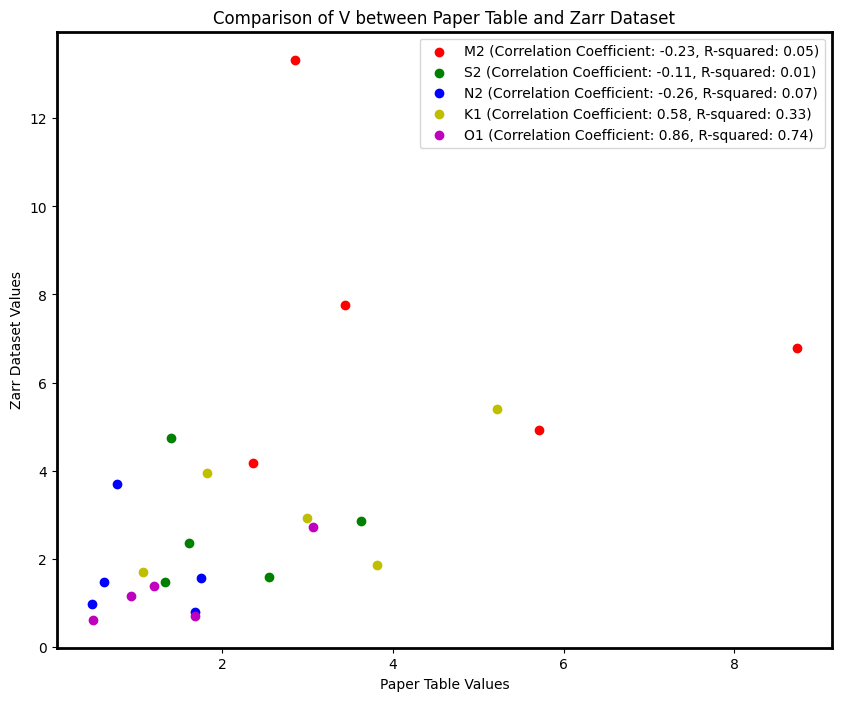

In [119]:
# Now you can call the plotting function
plot_scatter_uv(paper_df, zarr_df, ["M2", "S2", "N2", "K1", "O1"] , 'u')
plot_scatter_uv(paper_df, zarr_df, ["M2", "S2", "N2", "K1", "O1"] , 'v')


In [80]:
#Incremental inference of boundary forcingfor a three-dimensional tidal model: tides in the Taiwan Strait
raw_data3 = {
    "Location": ["WC1", "WC2", "WC3", "WC4", "EWC", "PHC"],
    "Lat": ["24D59M", "24D50M", "24D39M", "24D28M", "25D00M", "23D51M"],
    "Lon": ["119D29M", "119D48M", "120D08M", "120D28M", "120D08M", "119D52M"],
    "K1_Ma": [0.091, 0.047, 0.031, 0.015, 0.113, 0.075],
    "K1_Mi": [0.001, 0.017, 0.013, 0.000, 0.010, 0.033],
    "K1_O": [29, 38, 31, 49, 40, 69],
    "K1_G": [305, 238, 223, 213, 288, 338],
    "M2_Ma": [0.295, 0.221, 0.127, 0.053, 0.310, 0.693],
    "M2_Mi": [0.065, 0.105, 0.068, .010, 0.110, 0.060],
    "M2_O": [31, 37, 32, 48, 25, 67],
    "M2_G": [264, 252, 233, 224, 214, 348]
}

# Mapping from abbreviation to full location name
abbr_to_location = {
    "MT": "Matsu",
    "WC": "Wuchou",
    "KM": "Kinmen",
    "P1": "Taipower1",
    "TS": "Tamsuei",
    "HC": "Hsinchu",
    "TC": "Taichung",
    "BD": "Budai",
    "DG": "Dongee",
    "KS": "Kaohsiung",
    "P3": "Taipower3"
}

# Convert Station abbreviation to Location and Lat/Lon to Decimal
# raw_data3["Location"] = [abbr_to_location[station[:-1]] for station in raw_data3["Station"]]                       
raw_data3["Latitude"] = [convert_dm_to_decimal(lat) for lat in raw_data3["Lat"]]
raw_data3["Longitude"] = [convert_dm_to_decimal(lon) for lon in raw_data3["Lon"]]

# Delete unused columns
# del raw_data3["Station"]
del raw_data3["Lat"]
del raw_data3["Lon"]

paper3_df = pd.DataFrame(raw_data3)
print(paper3_df)

  Location  K1_Ma  K1_Mi  K1_O  K1_G  M2_Ma  M2_Mi  M2_O  M2_G   Latitude  \
0      WC1  0.091  0.001    29   305  0.295  0.065    31   264  24.983333   
1      WC2  0.047  0.017    38   238  0.221  0.105    37   252  24.833333   
2      WC3  0.031  0.013    31   223  0.127  0.068    32   233  24.650000   
3      WC4  0.015  0.000    49   213  0.053  0.010    48   224  24.466667   
4      EWC  0.113  0.010    40   288  0.310  0.110    25   214  25.000000   
5      PHC  0.075  0.033    69   338  0.693  0.060    67   348  23.850000   

    Longitude  
0  119.483333  
1  119.800000  
2  120.133333  
3  120.466667  
4  120.133333  
5  119.866667  


In [19]:
# Initialize a dictionary to store zarr results for each location
zarr_results = {}

# Get zarr results for each location in paper3_df
locations = paper3_df['Location'].unique()
for loc in locations:
    loc_filter = paper3_df['Location'] == loc
    x, y = paper3_df.loc[loc_filter, ['Longitude', 'Latitude']].iloc[0]
    dsub = dz.sel(lon=x, lat=y, method='nearest')
    zarr_results[loc] = get_tide_constituent(dsub, 'harmonic', ["k1", "m2"])

print(zarr_results)

{'WC1': {'k1_u': (-7.82968324002182+657.6360720527781j), 'm2_u': (-968.6285722533379+769.8417928552915j), 'k1_v': (117.83545135022021+236.48227232294352j), 'm2_v': (2820.428632886009-138.93149609926462j)}, 'WC2': {'k1_u': (100.24994834624937+592.8887082100272j), 'm2_u': (-437.5603987083659+664.714240692568j), 'k1_v': (135.33637038606707+420.08607828545206j), 'm2_v': (1182.07463659544-18.769223158173833j)}, 'WC3': {'k1_u': (97.30838576648439+466.5125221634088j), 'm2_u': (-158.80765111066387+349.1186622123624j), 'k1_v': (116.16849692210728+412.04162912086485j), 'm2_v': (785.2614413199788-172.25343398990736j)}, 'WC4': {'k1_u': (60.976057258396644+306.4693800649206j), 'm2_u': (217.75877067011157+284.04187047905845j), 'k1_v': (89.59159402274987+436.2011323895039j), 'm2_v': (292.1889925395493+361.32558862631714j)}, 'EWC': {'k1_u': (3.492374788041785+609.9916018951096j), 'm2_u': (-1784.3212479494916-92.5343515871941j), 'k1_v': (2.1851504078483974+478.65099127398304j), 'm2_v': (-232.5353687517

In [66]:
# Evaluate zarr_results to calculate tidal ellipse parameters
major_list = []
minor_list = []
inclination_list = []
lon_list = []
lat_list = []

for loc, amplitudes in zarr_results.items():
    k1_u = amplitudes["k1_u"]/100 #to m/s
    k1_v = amplitudes["k1_v"]/100
    major, minor, inclination, phase = tidal_ellipse(np.atleast_1d(k1_u), np.atleast_1d(k1_v)) #calculate_ellipse_parameters(k1_u, k1_v)
    #print(major, minor, inclination, phase, k1_u, k1_v)
    major_list.append(major[0])
    minor_list.append(minor[0])
    inclination_list.append(inclination[0])
    
    loc_filter = paper3_df['Location'] == loc
    lon, lat = paper3_df.loc[loc_filter, ['Longitude', 'Latitude']].iloc[0]
    lon_list.append(lon)
    lat_list.append(lat)

print(major_list, minor_list)
print(inclination_list)

[6.996386604356102, 7.441305371822578, 6.402275533935816, 5.4400105444937825, 7.753794597343117, 4.633476733035087] [1.134077190778633, 0.5123536296104998, 0.22021783695481334, 0.01579509906079224, -0.004368251599641049, 0.2247281570977271]
[20.221950004701682, 36.19229879250122, 41.92718106050492, 54.942424854297485, 38.120558934602144, 89.51054739270094]


In [61]:
def calculate_ellipse(u, v, mode="radian"):
    """
    Calculate tidal ellipse parameters.

    Parameters:
    - u: Real component of complex amplitude.
    - v: Imaginary component of complex amplitude.
    - mode: "radian" or "degree". Determines the unit for the inclination and phase.

    Returns:
    - major: Major axis of the tidal ellipse.
    - minor: Minor axis of the tidal ellipse.
    - inclination: Inclination of the tidal ellipse.
    - phase: Phase of the tidal ellipse.
    """
    # Major and minor axis
    U = u + 1j * v
    V = u - 1j * v

    major = np.abs(U)
    minor = np.abs(V)

    # Inclination
    inclination = np.angle(U) * 0.5
    if np.isscalar(inclination):
        inclination = inclination if inclination >= 0 else inclination + np.pi
    else:
        inclination[inclination < 0] += np.pi

    if mode == "degree":
        inclination = np.degrees(inclination)

    # Phase of maximum velocity
    phase = np.angle(-V)
    if mode == "degree":
        phase = np.degrees(phase)
    # Ensure phase is within [0, 2pi] or [0, 360]
    phase %= (2 * np.pi if mode == "radian" else 360)

    return major, minor, inclination, phase

# Example:
u, v = 1.0, 0.5
print(calculate_ellipse(u, v, mode="degree"))


(1.118033988749895, 1.118033988749895, 13.282525588538995, 153.434948822922)


In [ ]:
# Evaluate zarr_results to calculate tidal ellipse parameters
major_list = []
minor_list = []
inclination_list = []
lon_list = []
lat_list = []

for loc, amplitudes in zarr_results.items():
    k1_u = amplitudes["k1_u"]/100 #to m/s
    k1_v = amplitudes["k1_v"]/100
    #major, minor, inclination, phase = tidal_ellipse(np.atleast_1d(k1_u), np.atleast_1d(k1_v)) #calculate_ellipse_parameters(k1_u, k1_v)
    major, minor, inclination, phase = calculate_ellipse(k1_u, k1_v, mode="degree")    
    #print(major, minor, inclination, phase, k1_u, k1_v)
    major_list.append(major)
    minor_list.append(minor)
    inclination_list.append(inclination)
    
    loc_filter = paper3_df['Location'] == loc
    lon, lat = paper3_df.loc[loc_filter, ['Longitude', 'Latitude']].iloc[0]
    lon_list.append(lon)
    lat_list.append(lat)

print(major_list, minor_list)
print(inclination_list)

In [85]:
def get_tidal_ellipse(data, constituent, loc_data, unit_conv=1/100):
    major_list = []
    minor_list = []
    inclination_list = []
    phase_list = []
    lon_list = []
    lat_list = []    

    for loc, amplitudes in data.items():
        loc_filter = loc_data['Location'] == loc
        lon, lat = loc_data.loc[loc_filter, ['Longitude', 'Latitude']].iloc[0]
        lon_list.append(lon)
        lat_list.append(lat)
        k_u = amplitudes[f"{constituent}_u"] * unit_conv  # to m/s
        k_v = amplitudes[f"{constituent}_v"] * unit_conv
        major, minor, inclination, phase = tidal_ellipse(np.atleast_1d(k_u), np.atleast_1d(k_v))
        major_list.append(major[0])
        minor_list.append(minor[0])
        inclination_list.append(inclination[0])
        phase_list.append(phase[0])

    return lon_list, lat_list, major_list, minor_list, inclination_list, phase_list

In [86]:
lon_list, lat_list, major_list, minor_list, inclination_list,_ = get_tidal_ellipse(zarr_results, "k1", paper3_df, unit_conv=1/100)

print(major_list, minor_list)
print(inclination_list)
print(lon_list, lat_list)

[6.996386604356102, 7.441305371822578, 6.402275533935816, 5.4400105444937825, 7.753794597343117, 4.633476733035087] [1.134077190778633, 0.5123536296104998, 0.22021783695481334, 0.01579509906079224, -0.004368251599641049, 0.2247281570977271]
[20.221950004701682, 36.19229879250122, 41.92718106050492, 54.942424854297485, 38.120558934602144, 89.51054739270094]
[119.48333333333333, 119.8, 120.13333333333334, 120.46666666666667, 120.13333333333334, 119.86666666666666] [24.983333333333334, 24.833333333333332, 24.65, 24.466666666666665, 25.0, 23.85]


In [92]:
def plot_multiple_ellipses(lon_list, lat_list, major_list, minor_list, inclination_list, scale_factor=0.01):
    fig, ax = plt.subplots()
    ax.set_aspect('equal', 'box')
    
    for lon, lat, major, minor, inclination in zip(lon_list, lat_list, major_list, minor_list, inclination_list):
        scaled_major = major * scale_factor
        scaled_minor = minor * scale_factor
        
        ellipse = patches.Ellipse((lon, lat), width=2*scaled_major, height=2*scaled_minor, angle=inclination,
                                  fill=False, edgecolor='r', linewidth=2)
        ax.add_patch(ellipse)
    
    ax.set_xlim(min(lon_list) - 0.1, max(lon_list) + 0.1)
    ax.set_ylim(min(lat_list) - 0.1, max(lat_list) + 0.1)

    plt.show()

In [93]:
def plot_ellipses_map(lons, lats, major_axes, minor_axes, inclinations, annotations=None, scale_factor=0.0001, buf=2.5):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_aspect('equal', 'box')
    
    # Create the Basemap object
    lon_min, lon_max, lat_min, lat_max = np.min(lons)-buf, np.max(lons)+buf, np.min(lats)-buf, np.max(lats)+buf

    # Round the min/max to the nearest 5 for setting ticks
    lon_start = int(5 * (lon_min // 5))
    lon_end = int(5 * (lon_max // 5 + 1))

    lat_start = int(5 * (lat_min // 5))
    lat_end = int(5 * (lat_max // 5 + 1))

    m = Basemap(projection='merc', llcrnrlat=lat_min, urcrnrlat=lat_max,
                llcrnrlon=lon_min, urcrnrlon=lon_max, lat_ts=20, ax=ax, resolution='i')

    # Convert x, y to map projection coordinates
    x_map, y_map = m(lons, lats)
    
    # Draw ellipses on the map
    for i, (x, y, major, minor, inclination) in enumerate(zip(x_map, y_map, major_axes, minor_axes, inclinations)):
        scaled_major = major * scale_factor
        scaled_minor = minor * scale_factor
        
        ellipse = patches.Ellipse((x, y), width=2*scaled_major*m.xmax, height=2*scaled_minor*m.ymax, angle=inclination,
                                  fill=False, edgecolor='r', linewidth=2)
        ax.add_patch(ellipse)
        
        # Add annotations if provided
        if annotations is not None and len(annotations) > 0:
            ax.text(x, y, annotations[i], color='grey', fontsize=8, ha='center', va='center')

    # Add coastlines
    m.drawcoastlines()

    # Add ticks for meridians and parallels
    parallels = range(lat_start, lat_end, 5)
    meridians = range(lon_start, lon_end, 5)
    m.drawparallels(parallels, labels=[1, 0, 0, 0], linewidth=0.5, fontsize=10)
    m.drawmeridians(meridians, labels=[0, 0, 0, 1], linewidth=0.5, fontsize=10)

    plt.show()

In [51]:
print( paper3_df['Location'].ravel())

['WC1' 'WC2' 'WC3' 'WC4' 'EWC' 'PHC']


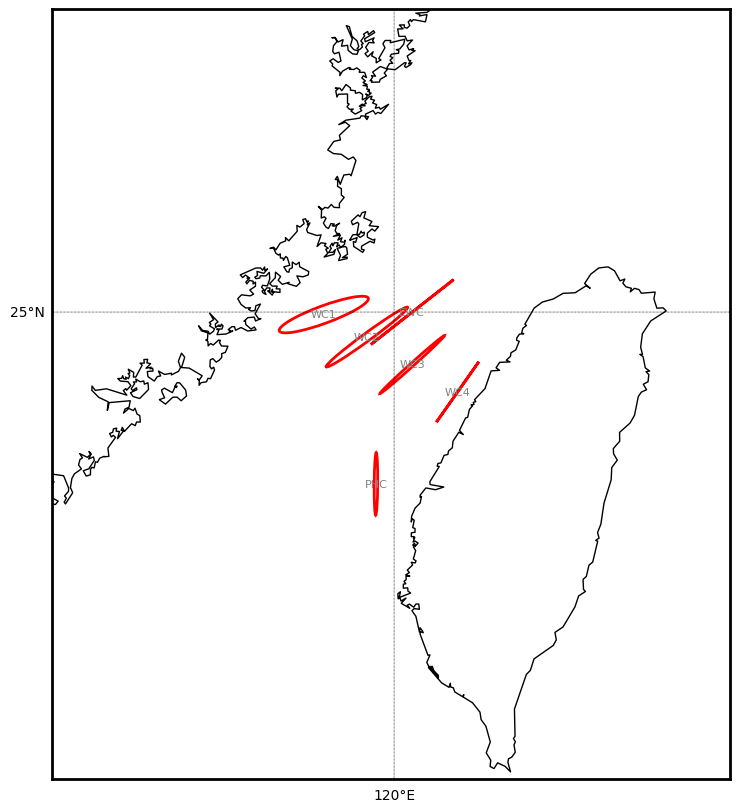

In [95]:
# Plot multiple ellipses for the locations
plot_ellipses_map(lon_list, lat_list, major_list, minor_list, inclination_list, 
                  paper3_df['Location'].ravel(), 0.01, 2)

In [88]:
lon_list, lat_list, major_m2, minor_m2, inclination_m2, _ = get_tidal_ellipse(zarr_results, "m2", paper3_df, unit_conv=1/100)
print(major_m2, minor_m2, inclination_m2)
print(lon_list, lat_list)


[30.07735874384372, 12.917658327652049, 8.41009899096858, 5.86493988140032, 18.034161529769463, 72.15434237485749] [6.771574711727606, 6.019118605061219, 2.9344988792394306, 0.07352320860234318, -1.9972011667452012, 2.7449930417298916] [110.69334856003377, 117.09506075747872, 108.26089888177307, 52.39816706846944, 7.851316614418806, 83.04268327150183]
[119.48333333333333, 119.8, 120.13333333333334, 120.46666666666667, 120.13333333333334, 119.86666666666666] [24.983333333333334, 24.833333333333332, 24.65, 24.466666666666665, 25.0, 23.85]


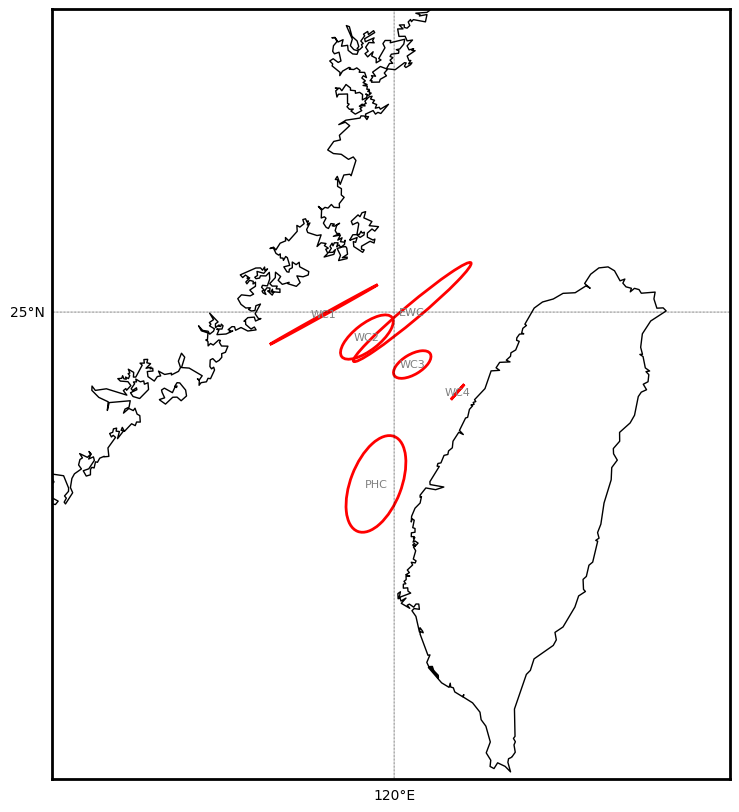

In [97]:
plot_ellipses_map(lon_list, lat_list, 
                  paper3_df['K1_Ma'].ravel(), 
                  paper3_df['K1_Mi'].ravel(), 
                  paper3_df['K1_O'].ravel(),
                  paper3_df['Location'].ravel(), 1, 2)

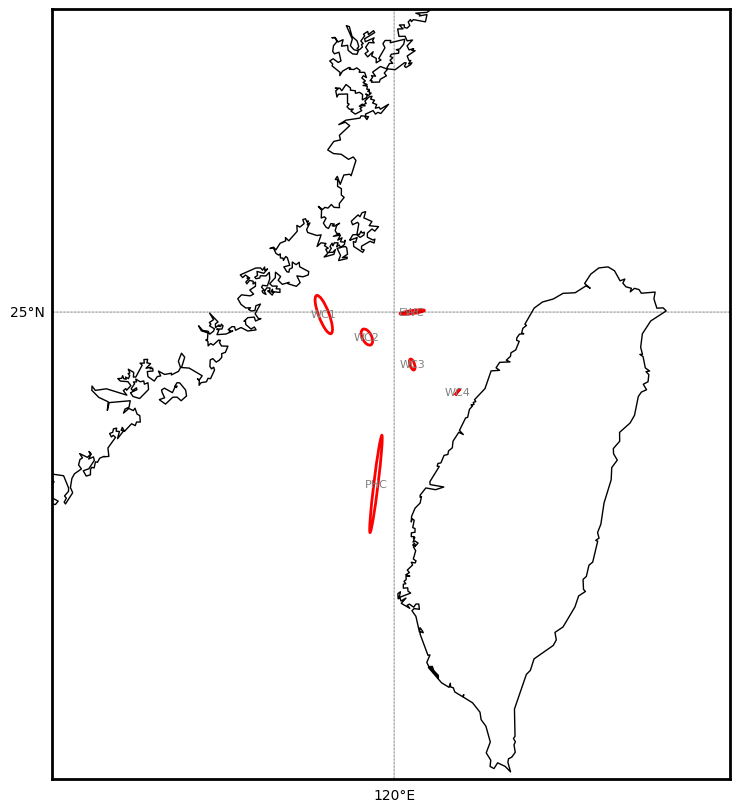

In [103]:
plot_ellipses_map(lon_list, lat_list, major_m2, minor_m2, inclination_m2, 
                  paper3_df['Location'].ravel(), 0.001, 2)

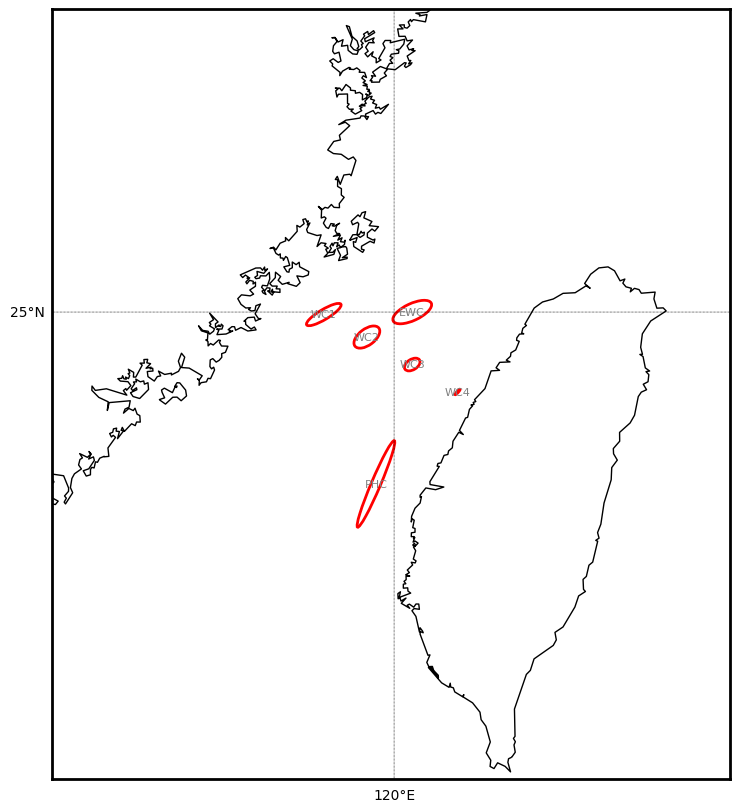

In [102]:
plot_ellipses_map(lon_list, lat_list, 
                  paper3_df['M2_Ma'].ravel(), 
                  paper3_df['M2_Mi'].ravel(), 
                  paper3_df['M2_O'].ravel(),
                  paper3_df['Location'].ravel(), 0.1, 2)